In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test])

In [24]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

In [5]:
def generator():
    model=Sequential()
    model.add(dense(128,input_shape=(100),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(784,activation=functions.tanh))
    return model
g=generator()

In [6]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 128)                leakyRelu        12928
__________________________________________________________________________________________
2 dropout(dropout)        (None, 128)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 256)                leakyRelu        33024
__________________________________________________________________________________________
4 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
5 dense(

In [7]:
def discriminator():
    model=Sequential()
    model.add(dense(256,input_shape=(784),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(128,activation=functions.leakyRelu))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()

In [8]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 784)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 256)                leakyRelu        200960
__________________________________________________________________________________________
2 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 128)                leakyRelu        32896
__________________________________________________________________________________________
4 dense(dense)            (None, 1)                  sigmoid          129
Total Params: 233,985
Trainable Params: 233,985
Non-trainable Params: 0


In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.001)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

In [10]:
def run():
    batch_size=128
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_dis=np.zeros((2*batch_size,1),dtype=np.float32)
    y_dis[:batch_size]=0.9
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.normal(-1,1,(batch_size,100)).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[step*batch_size:(step+1)*batch_size]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_dis[:batch_size]=np.random.uniform(0.7,1,(batch_size,1)).astype(np.float32)
        y_dis[batch_size:]=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.fit(real_images,y_dis[:batch_size])
        dout2=d.fit(generated_images,y_dis[batch_size:])
        dloss=d.loss(logits=dout2,labels=y_dis[batch_size:]).mean()
        # Treat noised input of generator as real data
        noise=np.random.normal(-1,1,(batch_size,100)).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_fit(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Dloss: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,time()-stt),end='')

EPOCH: 1 / 40
Progress: 99.66 %     Dloss: 0.21643191576004028     Sample time: 0.058s    _
Epoch time: 0:19s


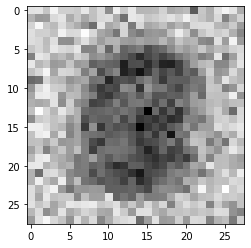

[0.09278005]
EPOCH: 2 / 40
Progress: 99.66 %     Dloss: 0.2049795687198639     Sample time: 0.031s    __
Epoch time: 0:20s


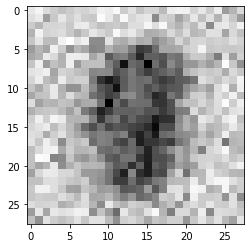

[0.07919713]
EPOCH: 3 / 40
Progress: 99.66 %     Dloss: 0.1945512294769287     Sample time: 0.029s    __
Epoch time: 0:21s


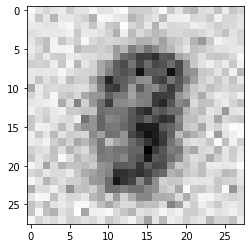

[0.12948568]
EPOCH: 4 / 40
Progress: 99.66 %     Dloss: 0.20074477791786194     Sample time: 0.028s    _
Epoch time: 0:17s


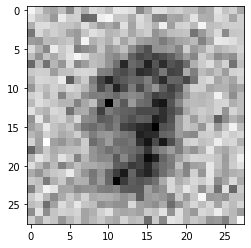

[0.07612292]
EPOCH: 5 / 40
Progress: 99.66 %     Dloss: 0.20184193551540375     Sample time: 0.028s    _
Epoch time: 0:21s


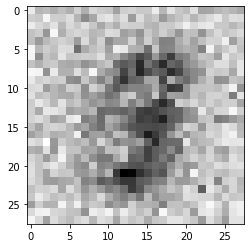

[0.05270289]
EPOCH: 6 / 40
Progress: 99.66 %     Dloss: 0.20284390449523926     Sample time: 0.028s    _
Epoch time: 0:17s


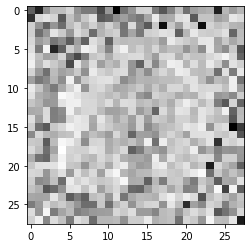

[0.04889477]
EPOCH: 7 / 40
Progress: 99.66 %     Dloss: 0.1906559318304062     Sample time: 0.028s    __
Epoch time: 0:19s


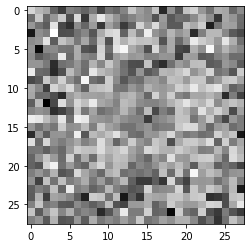

[0.04211712]
EPOCH: 8 / 40
Progress: 99.66 %     Dloss: 0.19054415822029114     Sample time: 0.031s    _
Epoch time: 0:18s


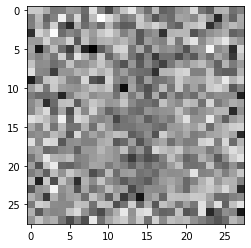

[0.05097912]
EPOCH: 9 / 40
Progress: 99.66 %     Dloss: 0.1978086531162262     Sample time: 0.049s    __
Epoch time: 0:18s


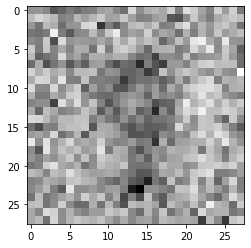

[0.05245757]
EPOCH: 10 / 40
Progress: 99.66 %     Dloss: 0.18351471424102783     Sample time: 0.027s    _
Epoch time: 0:17s


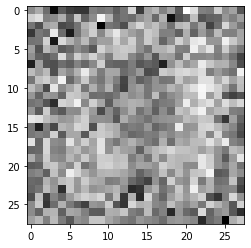

[0.0543091]
EPOCH: 11 / 40
Progress: 99.66 %     Dloss: 0.19061298668384552     Sample time: 0.027s    _
Epoch time: 0:18s


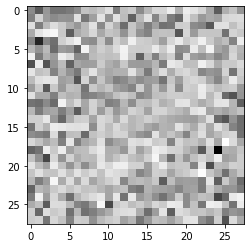

[0.04662333]
EPOCH: 12 / 40
Progress: 99.66 %     Dloss: 0.21161100268363953     Sample time: 0.031s    _
Epoch time: 0:18s


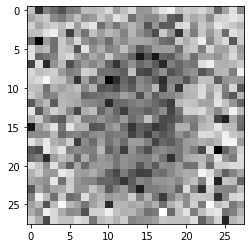

[0.0584105]
EPOCH: 13 / 40
Progress: 99.66 %     Dloss: 0.19679118692874908     Sample time: 0.027s    _
Epoch time: 0:17s


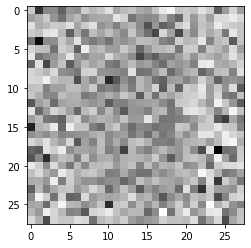

[0.05714159]
EPOCH: 14 / 40
Progress: 99.66 %     Dloss: 0.2071014940738678     Sample time: 0.028s    __
Epoch time: 0:18s


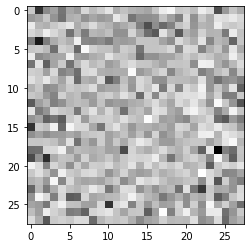

[0.05250797]
EPOCH: 15 / 40
Progress: 99.66 %     Dloss: 0.1993214637041092     Sample time: 0.027s    __
Epoch time: 0:21s


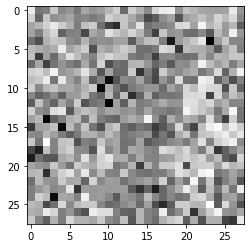

[0.05425591]
EPOCH: 16 / 40
Progress: 99.66 %     Dloss: 0.19893896579742432     Sample time: 0.029s    _
Epoch time: 0:18s


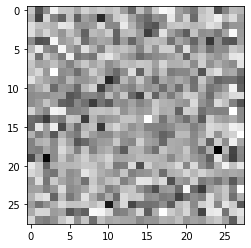

[0.0510239]
EPOCH: 17 / 40
Progress: 99.66 %     Dloss: 0.20544925332069397     Sample time: 0.027s    _
Epoch time: 0:18s


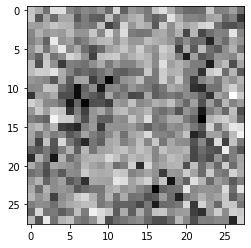

[0.05797721]
EPOCH: 18 / 40
Progress: 99.66 %     Dloss: 0.1914665699005127     Sample time: 0.044s    __
Epoch time: 0:18s


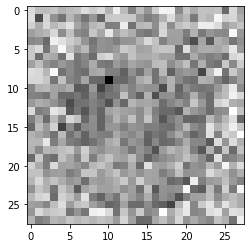

[0.04991039]
EPOCH: 19 / 40
Progress: 99.66 %     Dloss: 0.1992303431034088     Sample time: 0.027s    __
Epoch time: 0:18s


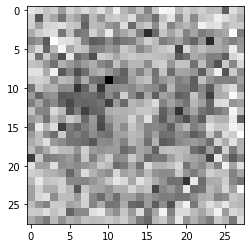

[0.05692412]
EPOCH: 20 / 40
Progress: 99.66 %     Dloss: 0.4582894444465637     Sample time: 0.030s    __
Epoch time: 0:21s


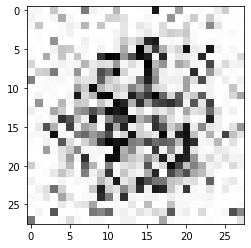

[0.4541304]
EPOCH: 21 / 40
Progress: 99.66 %     Dloss: 0.19049176573753357     Sample time: 0.030s    _
Epoch time: 0:18s


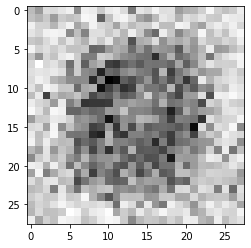

[0.08938627]
EPOCH: 22 / 40
Progress: 99.66 %     Dloss: 0.19216817617416382     Sample time: 0.027s    _
Epoch time: 0:20s


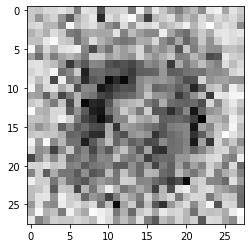

[0.05988093]
EPOCH: 23 / 40
Progress: 99.66 %     Dloss: 0.19237099587917328     Sample time: 0.053s    _
Epoch time: 0:23s


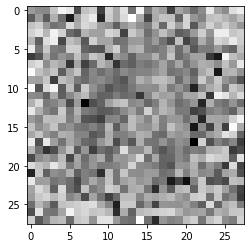

[0.05001115]
EPOCH: 24 / 40
Progress: 99.66 %     Dloss: 0.19746950268745422     Sample time: 0.030s    _
Epoch time: 0:17s


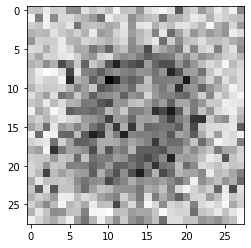

[0.06354485]
EPOCH: 25 / 40
Progress: 99.66 %     Dloss: 0.19371572136878967     Sample time: 0.046s    _
Epoch time: 0:18s


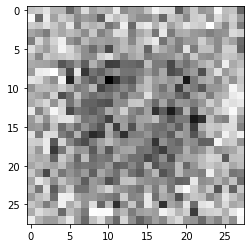

[0.05868286]
EPOCH: 26 / 40
Progress: 99.66 %     Dloss: 0.19611485302448273     Sample time: 0.026s    _
Epoch time: 0:17s


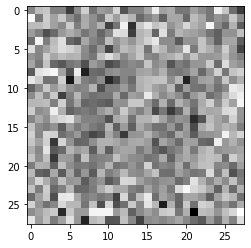

[0.05252554]
EPOCH: 27 / 40
Progress: 50.10 %     Dloss: 0.2061224728822708     Sample time: 0.062s    __

KeyboardInterrupt: 

In [11]:
epochs=40
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

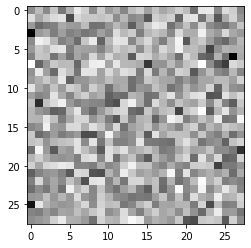

[[0.4971977]]


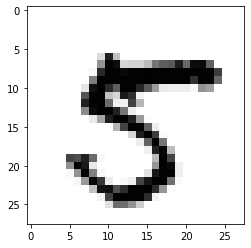

[[0.4967198]]


In [11]:
noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
gen=g.predict(noise)
plt.imshow(gen.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(gen))
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))

In [43]:
model=Sequential()
model.add(dense(128*7*7,activation=functions.relu,input_shape=100))
model.add(reshape((7,7,128)))
model.add(upsampling())
model.add(conv2d(128,kernel_size=3))
model.add(BatchNormalization())
model.add(Activation(functions.relu))
model.add(upsampling())
model.add(conv2d(64,kernel_size=3))
model.add(BatchNormalization())
model.add(Activation(functions.relu))
model.add(conv2d(1,kernel_size=3))
model.add(Activation(functions.tanh))

model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               relu             633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 14, 14, 128)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 14, 14, 128)        echo             147584
__________________________________________________________________________________________
5 Batc

In [44]:
model.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.001)

In [45]:
gen=model.forward(noise)

In [ ]:
#BEST btsz=32, dout1+dout2=real+fake